In [1]:
%load_ext autoreload
%autoreload 2

<Axes: title={'center': 'Performance Gains with Reinforcement Learning\n(Base Model: Hermes 2 Theta Llama 3 8B)'}, xlabel='Step', ylabel='Mean Reward'>

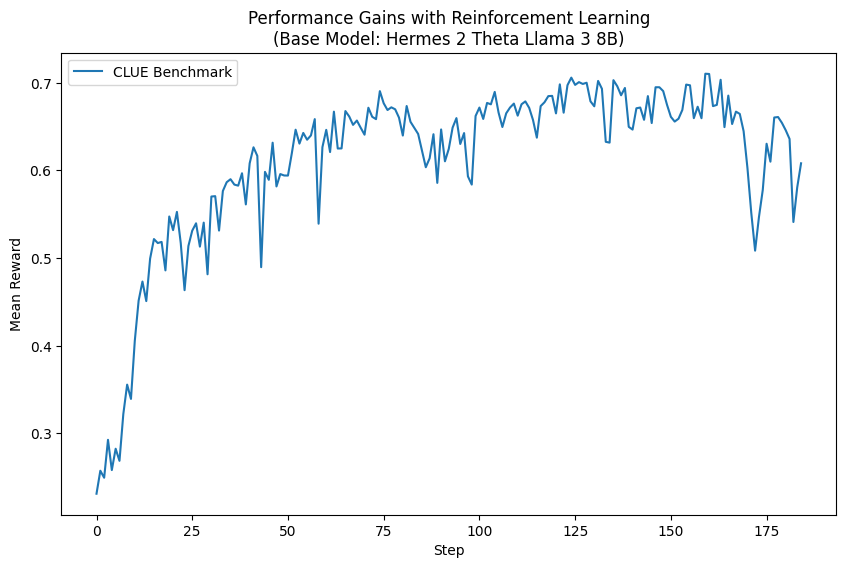

In [32]:
import wandb

api = wandb.Api()
run = api.run("bradhilton/atreides-experiments/rl132")
run.history().drop(index=[85]).rename(
    columns={"variable_clue/avg": "CLUE Benchmark"}
).plot(
    x="_step",
    y="CLUE Benchmark",
    xlabel="Step",
    ylabel="Mean Reward",
    title="Performance Gains with Reinforcement Learning\n(Base Model: Hermes 2 Theta Llama 3 8B)",
    figsize=(10, 6),
)

In [1]:
from dataclasses import dataclass
from lib.clue import Clue
from lib.utils import black_print
from ortools.sat.python import cp_model
import random

num_players = random.randint(3, 6)
num_weapons = max(
    3,
    min(
        num_players + random.randint(-1, 5),
        len(Clue.weapons),
    ),
)
num_suspects = min(num_weapons + random.randint(0, num_weapons - 1), len(Clue.suspects))
num_rooms = min(num_suspects + random.randint(0, num_suspects - 2), len(Clue.rooms))
elements = {
    "suspect": random.sample(Clue.suspects, k=num_suspects),
    "weapon": random.sample(Clue.weapons, k=num_weapons),
    "room": random.sample(Clue.rooms, k=num_rooms),
}
if random.random() < 0.1:
    elements["motive"] = random.sample(
        Clue.motives,
        k=max(3, min(num_weapons + random.randint(-1, 3), len(Clue.motives))),
    )
frequency = random.choice([0.25, 0.5, 1.0])
start = 24.0 - frequency
end = 0.0
for _ in range(random.randint(1, num_weapons)):
    if random.randint(0, 1):
        end += frequency
    else:
        start -= frequency


def format_time(time: float) -> str:
    return f"{int(time):02d}:{int(60 * (time - int(time))):02d}"


elements["time"] = Clue.get_times(
    format_time(start), format_time(end), f"{int(frequency * 60)}min"
)

suspect_locations = [
    [random.randrange(len(elements["room"]))] for _ in range(len(elements["suspect"]))
]

weapon_locations = [
    [random.randrange(len(elements["room"]))] for _ in range(len(elements["weapon"]))
]

suspect_move_probability = 0.8
suspect_moves_weapon_probability = 0.5


@dataclass
class WeaponMove:
    suspect: int
    weapon: int
    from_room: int
    to_room: int
    time: int


weapon_moves: list[WeaponMove] = []

for time in range(1, len(elements["time"])):
    for suspect in range(len(elements["suspect"])):
        suspect_locations[suspect].append(
            random.randrange(len(elements["room"]))
            if random.random() < suspect_move_probability
            else suspect_locations[suspect][-1]
        )
    for weapon in range(len(elements["weapon"])):
        for suspect in range(len(elements["suspect"])):
            if (
                suspect_locations[suspect][-2] == weapon_locations[weapon][-1]
                and random.random() < suspect_moves_weapon_probability
            ):
                weapon_locations[weapon].append(suspect_locations[suspect][-1])
                weapon_moves.append(
                    WeaponMove(
                        suspect=suspect,
                        weapon=weapon,
                        from_room=weapon_locations[weapon][-2],
                        to_room=weapon_locations[weapon][-1],
                        time=time,
                    )
                )
                break
        else:
            weapon_locations[weapon].append(weapon_locations[weapon][-1])

while True:
    murderer = random.randrange(len(elements["suspect"]))
    murder_time = random.randrange(len(elements["time"]))
    murder_location = suspect_locations[murderer][murder_time]
    possible_weapons = [
        weapon
        for weapon, locations in enumerate(weapon_locations)
        if locations[murder_time] == murder_location
    ]
    if not possible_weapons:
        continue
    else:
        murder_weapon = random.choice(possible_weapons)
        break

victim_locations = [murder_location for _ in range(len(elements["time"]))]
for time in range(murder_time):
    if random.random() < suspect_move_probability:
        victim_locations[time] = random.randrange(len(elements["room"]))

black_print(elements)
black_print(
    {
        "murderer": elements["suspect"][murderer],
        "murder_weapon": elements["weapon"][weapon],
        "murder_location": elements["room"][murder_location],
        "murder_time": elements["time"][murder_time],
    }
)

model = cp_model.CpModel()

victim_location_vars = [
    model.new_int_var(0, len(elements["room"]) - 1, f"Mr. Boddy's location at {time}")
    for time in elements["time"]
]

suspect_location_vars = [
    [
        model.new_int_var(
            0, len(elements["room"]) - 1, f"{suspect}'s location at {time}"
        )
        for time in elements["time"]
    ]
    for suspect in elements["suspect"]
]

weapon_location_vars = [
    [
        model.new_int_var(
            0, len(elements["room"]) - 1, f"{weapon}'s location at {time}"
        )
        for time in elements["time"]
    ]
    for weapon in elements["weapon"]
]

murderer_var = model.new_int_var(0, len(elements["suspect"]) - 1, "Murderer")
murder_weapon_var = model.new_int_var(0, len(elements["weapon"]) - 1, "Murder weapon")
murder_location_var = model.new_int_var(0, len(elements["room"]) - 1, "Murder location")
murder_time_var = model.new_int_var(0, len(elements["time"]) - 1, "Murder time")

model.add_element(murder_time_var, victim_location_vars, murder_location_var)

# First get each suspect's location at the murder time
suspect_murder_location_vars = []
for suspect_idx in range(len(elements["suspect"])):
    # For each suspect, create a variable representing their location at murder_time
    suspect_location_at_murder_var = model.new_int_var(
        0,
        len(elements["room"]) - 1,
        f"{elements['suspect'][suspect_idx]}'s location at murder time",
    )
    # Add constraint that this location matches their location at murder_time
    model.add_element(
        murder_time_var,
        suspect_location_vars[suspect_idx],
        suspect_location_at_murder_var,
    )
    suspect_murder_location_vars.append(suspect_location_at_murder_var)

# Then constrain murderer's location to match murder_location
model.add_element(murderer_var, suspect_murder_location_vars, murder_location_var)

# First get each weapon's location at the murder time
weapon_murder_location_vars = []
for weapon_idx in range(len(elements["weapon"])):
    # For each weapon, create a variable representing their location at murder_time
    weapon_location_at_murder_var = model.new_int_var(
        0,
        len(elements["room"]) - 1,
        f"{elements['suspect'][weapon_idx]}'s location at murder time",
    )
    # Add constraint that this location matches their location at murder_time
    model.add_element(
        murder_time_var, weapon_location_vars[weapon_idx], weapon_location_at_murder_var
    )
    weapon_murder_location_vars.append(weapon_location_at_murder_var)

# Then constrain murder weapon's location to match murder_location
model.add_element(murderer_var, weapon_murder_location_vars, murder_location_var)

{
    "suspect": [
        "Colonel Mustard",
        "Madame Rose",
        "Miss Scarlet",
        "Professor Plum",
        "Mr. Green",
    ],
    "weapon": ["Wrench", "Poison", "Revolver", "Candlestick"],
    "room": ["Gazebo", "Ballroom", "Carriage House", "Cloak Room", "Billiard Room"],
    "time": ["11:00 PM", "11:30 PM", "12:00 AM"],
}
{
    "murderer": "Miss Scarlet",
    "murder_weapon": "Candlestick",
    "murder_location": "Gazebo",
    "murder_time": "12:00 AM",
}


In [2]:
def constraints():
    for element, vars, locations in zip(
        ["Mr. Boddy", "The Murderer", "The Murder Weapon"]
        + elements["suspect"]
        + [f"the {weapon}" for weapon in elements["weapon"]],
        [
            victim_location_vars,
            suspect_location_vars[murderer],
            weapon_location_vars[murder_weapon],
        ]
        + suspect_location_vars
        + weapon_location_vars,
        [victim_locations, suspect_locations[murderer], weapon_locations[murder_weapon]]
        + suspect_locations
        + weapon_locations,
    ):
        for time, (var, location) in enumerate(zip(vars, locations)):
            yield f"{element} was in the {elements["room"][location]} at {elements["time"][time]}", var == location
            for other_location in range(len(elements["room"])):
                if location != other_location:
                    yield f"{element} was not in the {elements["room"][other_location]} at {elements["time"][time]}", var != other_location
            for other_element, location_vars, locations in zip(
                elements["suspect"]
                + [f"the {weapon}" for weapon in elements["weapon"]],
                suspect_location_vars + weapon_location_vars,
                suspect_locations + weapon_locations,
            ):
                if element != other_element:
                    if location == locations[time]:
                        yield f"{element.title()} was in the same room as {other_element} at {elements["time"][time]}", var == location_vars[
                            time
                        ]
                    else:
                        yield f"{element.title()} was not in the same room as {other_element} at {elements["time"][time]}", var != location_vars[
                            time
                        ]
    # yield f"Mr. Boddy was murdered at {elements["time"][murder_time]}", murder_time_var == murder_time


for description, constraint in constraints():
    print(description)
    model.add(constraint)

Mr. Boddy was in the Ballroom at 11:00 PM
Mr. Boddy was not in the Gazebo at 11:00 PM
Mr. Boddy was not in the Carriage House at 11:00 PM
Mr. Boddy was not in the Cloak Room at 11:00 PM
Mr. Boddy was not in the Billiard Room at 11:00 PM
Mr. Boddy was not in the same room as Colonel Mustard at 11:00 PM
Mr. Boddy was not in the same room as Madame Rose at 11:00 PM
Mr. Boddy was not in the same room as Miss Scarlet at 11:00 PM
Mr. Boddy was not in the same room as Professor Plum at 11:00 PM
Mr. Boddy was not in the same room as Mr. Green at 11:00 PM
Mr. Boddy was not in the same room as the Wrench at 11:00 PM
Mr. Boddy was not in the same room as the Poison at 11:00 PM
Mr. Boddy was not in the same room as the Revolver at 11:00 PM
Mr. Boddy was not in the same room as the Candlestick at 11:00 PM
Mr. Boddy was in the Billiard Room at 11:30 PM
Mr. Boddy was not in the Gazebo at 11:30 PM
Mr. Boddy was not in the Ballroom at 11:30 PM
Mr. Boddy was not in the Carriage House at 11:30 PM
Mr. Bod

In [3]:
class SolutionCallback(cp_model.CpSolverSolutionCallback):
    def __init__(self) -> None:
        super().__init__()
        self.num_solutions = 0
        self.murderer_candidates: set[int] = set()
        self.murder_weapon_candidates: set[int] = set()
        self.murder_location_candidates: set[int] = set()
        self.murder_time_candidates: set[int] = set()

    def on_solution_callback(self) -> None:
        self.num_solutions += 1
        self.murderer_candidates.add(self.value(murderer_var))
        self.murder_weapon_candidates.add(self.value(murder_weapon_var))
        self.murder_location_candidates.add(self.value(murder_location_var))
        self.murder_time_candidates.add(self.value(murder_time_var))


solver = cp_model.CpSolver()
solver.parameters.enumerate_all_solutions = True
solver.parameters.max_time_in_seconds = 1.0
callback = SolutionCallback()
status = solver.solve(model, callback)
assert status == cp_model.OPTIMAL or status == cp_model.FEASIBLE
callback.num_solutions, callback.murderer_candidates, callback.murder_weapon_candidates, callback.murder_location_candidates, callback.murder_time_candidates

(4, {2}, {0, 1, 2, 3}, {0}, {2})

In [27]:
from lib.clue import Clue, DeductiveSolver
import random

game = Clue(
    num_players=4,
    elements={
        "suspect": random.sample(Clue.suspects, k=6),
        "weapon": random.sample(Clue.weapons, k=6),
        "room": random.sample(Clue.rooms, k=6),
        # "motive": random.sample(Clue.motives, k=3),
        # "time": Clue.get_times("21:00", "03:00", "1h"),
    },
)
game.play(
    deductive_solver=DeductiveSolver(
        # note_cards_in_hand=False,
        # note_responses_to_suggestions=False,
        # note_cards_that_players_do_not_have=False,
        # check_unique_card_placement_constraints=False,
        # check_player_hand_size_constraints=False,
        check_solution_has_one_and_only_one_card_per_element=True,
        check_one_of_constraints=False,
        check_inverse_one_of_constraints=False,
        merge_and_check_disjoint_inverse_one_of_constraints=False,
        exhaustively_test_possible_assignments=False,
    ),
    cp_solver_max_solve_time_per_turn=0.01,
    check_cp_solver_grid=False,
    check_if_deductive_solver_and_cp_solver_grids_match=False,
    return_first_solver_as_winner=True,
    # print_playthrough=False,
)

Player 1's Hand: {'Conservatory', 'Dining Room', 'Rope'}
Player 2's Hand: {'Revolver', 'Knife', 'Miss Peach', 'Candlestick'}
Player 3's Hand: {'Library', 'Mrs. Peacock', 'Wrench', 'Colonel Mustard'}
Player 4's Hand: {'Courtyard', 'Ballroom', 'Mrs. White', 'Madame Rose'}
Solution: {'suspect': 'Professor Plum', 'weapon': 'Lead Pipe', 'room': 'Study'}
Player                   1  2  3  4
Element Card                       
Suspect Mrs. Peacock     ✗  ✗  ✓  ✗
        Miss Peach       ✗  ✓  ✗  ✗
        Colonel Mustard  ✗  ✗  ✓  ✗
        Madame Rose      ✗  ✗  ✗  ✓
        Professor Plum   ✗  ✗  ✗  ✗
        Mrs. White       ✗  ✗  ✗  ✓
Weapon  Revolver         ✗  ✓  ✗  ✗
        Lead Pipe        ✗  ✗  ✗  ✗
        Wrench           ✗  ✗  ✓  ✗
        Candlestick      ✗  ✓  ✗  ✗
        Knife            ✗  ✓  ✗  ✗
        Rope             ✓  ✗  ✗  ✗
Room    Dining Room      ✓  ✗  ✗  ✗
        Courtyard        ✗  ✗  ✗  ✓
        Ballroom         ✗  ✗  ✗  ✓
        Library          ✗  ✗  ✓  ✗
 

In [32]:
from lib.utils import black_print

prompt, follow_up, solution = game.get_prompt_and_follow_up_and_solution()

print(prompt)
display(None)
print(follow_up)
print("\nFollow Up:\n" + follow_up + "\n\nSolution:")
black_print(solution)

On a warm spring morning Edwin, Alejandro, Erica, and Daisy sat down to play a competitive sleuthing game.

They assembled 3 groups of cards, each for a separate category of data composed of the following:

Suspect:
- Mrs. Peacock
- Miss Peach
- Colonel Mustard
- Madame Rose
- Professor Plum
- Mrs. White

Weapon:
- Revolver
- Lead Pipe
- Wrench
- Candlestick
- Knife
- Rope

Room:
- Dining Room
- Courtyard
- Ballroom
- Library
- Conservatory
- Study

After randomly (and blindly) choosing one card from each group and placing them in the center of the table facedown, they shuffled the remaining cards and dealt out the following to each player:

- Edwin: 3 cards
- Alejandro: 4 cards (Revolver, Knife, Miss Peach, and Candlestick)
- Erica: 4 cards
- Daisy: 4 cards

The game proceeded as follows:

1. On their turn, a player asked about a set of exactly 3 cards, one from each of the game's categories. (Note: Players could ask about any cards, including those in their own hand.)
2. The player d

None

Fill out your answer like this:
Mrs. Peacock: <#LOCATION#>
Miss Peach: <#LOCATION#>
Colonel Mustard: <#LOCATION#>
Madame Rose: <#LOCATION#>
Professor Plum: <#LOCATION#>
Mrs. White: <#LOCATION#>
Revolver: <#LOCATION#>
Lead Pipe: <#LOCATION#>
Wrench: <#LOCATION#>
Candlestick: <#LOCATION#>
Knife: <#LOCATION#>
Rope: <#LOCATION#>
Dining Room: <#LOCATION#>
Courtyard: <#LOCATION#>
Ballroom: <#LOCATION#>
Library: <#LOCATION#>
Conservatory: <#LOCATION#>
Study: <#LOCATION#>
Where valid locations are Edwin, Alejandro, Erica, Daisy, or Solution.

Follow Up:
Fill out your answer like this:
Mrs. Peacock: <#LOCATION#>
Miss Peach: <#LOCATION#>
Colonel Mustard: <#LOCATION#>
Madame Rose: <#LOCATION#>
Professor Plum: <#LOCATION#>
Mrs. White: <#LOCATION#>
Revolver: <#LOCATION#>
Lead Pipe: <#LOCATION#>
Wrench: <#LOCATION#>
Candlestick: <#LOCATION#>
Knife: <#LOCATION#>
Rope: <#LOCATION#>
Dining Room: <#LOCATION#>
Courtyard: <#LOCATION#>
Ballroom: <#LOCATION#>
Library: <#LOCATION#>
Conservatory: <#LOCATION#>

In [ ]:
import asyncio
from lib.rl.episode import Episode, EpisodeCompletion
from lib.utils import return_exception
import re


@return_exception
def sample_random_episode(reward_follow_up_completion: bool = False) -> Episode:
    game = Clue(
        num_players=3,
        elements={
            "suspect": random.sample(Clue.suspects, k=3),
            "weapon": random.sample(Clue.weapons, k=3),
            "room": random.sample(Clue.rooms, k=3),
            # "motive": random.sample(Clue.motives, k=3),
            # "time": Clue.get_times("21:00", "03:00", "1h"),
        },
    )
    game.play(
        deductive_solver=DeductiveSolver(
            # note_cards_in_hand=False,
            # note_responses_to_suggestions=False,
            # note_cards_that_players_do_not_have=False,
            # check_unique_card_placement_constraints=False,
            # check_player_hand_size_constraints=False,
            check_solution_has_one_and_only_one_card_per_element=False,
            check_one_of_constraints=False,
            check_inverse_one_of_constraints=False,
            merge_and_check_disjoint_inverse_one_of_constraints=False,
            exhaustively_test_possible_assignments=False,
        ),
        cp_solver_max_solve_time_per_turn=0.01,
        check_cp_solver_grid=False,
        check_if_deductive_solver_and_cp_solver_grids_match=False,
        print_playthrough=False,
    )
    prompt, follow_up, solution = game.get_prompt_and_follow_up_and_solution()

    async def reward_completion(completion: EpisodeCompletion) -> EpisodeCompletion:
        if len(completion.messages) == 2:
            follow_up_completion = await completion.follow_up(
                messages=[
                    {"role": "user", "content": follow_up},
                ]
            )
        else:
            follow_up_completion = completion
        answer = follow_up_completion.last_assistant_message.get("content")
        assert isinstance(answer, str)
        if reward_follow_up_completion:
            completion = follow_up_completion
        completion.reward = sum(
            [
                bool(
                    re.search(
                        f"{key}: {value}",
                        answer,
                        re.IGNORECASE,
                    )
                )
                for key, value in solution.items()
            ]
        ) / len(solution)
        return completion

    async def on_sample(completions: list[EpisodeCompletion]) -> None:
        for completion in await asyncio.gather(
            *[reward_completion(completion) for completion in completions]
        ):
            completion.commit()

    return Episode(
        messages=[{"role": "user", "content": prompt}],
        on_sample=on_sample,
    )


sample_random_episode()

In [2]:
from lib.clue import Clue, DeductiveSolver

total_num_turns = 0
playthroughs = 1

for _ in range(playthroughs):
    game = Clue(
        num_players=3,
        elements={
            "suspect": Clue.suspects[:3],
            "weapon": Clue.weapons[:3],
            "room": Clue.rooms[:3],
            # "motive": Clue.motives[:6],
            # "time": Clue.get_times("21:00", "03:00", "1h"),
        },
    )
    game.play(
        deductive_solver=DeductiveSolver(
            # note_cards_in_hand=False,
            # note_responses_to_suggestions=False,
            # note_cards_that_players_do_not_have=False,
            # check_unique_card_placement_constraints=False,
            # check_player_hand_size_constraints=False,
            check_solution_has_one_and_only_one_card_per_element=False,
            check_one_of_constraints=False,
            check_inverse_one_of_constraints=False,
            merge_and_check_disjoint_inverse_one_of_constraints=False,
            exhaustively_test_possible_assignments=False,
        ),
        check_if_deductive_solver_and_cp_solver_grids_match=False,
    )
    total_num_turns += game.num_turns

print(f"Average number of turns: {total_num_turns / playthroughs}")

Player 1's Hand: {'Lead Pipe', 'Mr. Green'}
Player 2's Hand: {'Dining Room', 'Knife'}
Player 3's Hand: {'Miss Scarlet', 'Lounge'}
Solution: {'suspect': 'Mrs. White', 'weapon': 'Candlestick', 'room': 'Hall'}
Player                1  2  3
Element Card                 
Suspect Miss Scarlet  ✗  ✗  ✓
        Mr. Green     ✓  ✗  ✗
        Mrs. White    ✗  ✗  ✗
Weapon  Candlestick   ✗  ✗  ✗
        Knife         ✗  ✓  ✗
        Lead Pipe     ✓  ✗  ✗
Room    Hall          ✗  ✗  ✗
        Lounge        ✗  ✗  ✓
        Dining Room   ✗  ✓  ✗
Player 1's Simple Solver Grid:
Player                1  2  3
Element Card                 
Suspect Miss Scarlet  ✗      
        Mr. Green     ✓  ✗  ✗
        Mrs. White    ✗      
Weapon  Candlestick   ✗      
        Knife         ✗      
        Lead Pipe     ✓  ✗  ✗
Room    Hall          ✗      
        Lounge        ✗      
        Dining Room   ✗      
Player 1's CP-SAT Solver Grid:
Player                1  2  3
Element Card                 
Suspect Mis

In [4]:
print(game.get_prompt_and_follow_up_and_solution()[0])
display("--------------------")
print(
    "\n".join(
        f"{category.capitalize()}: {card}" for category, card in game.solution.items()
    )
)

On a warm autumn day Jada, Stephen, and Landon and sat down to play a casual deduction game.

They gathered 3 stacks of cards, each for a different category of information composed of the following:

Suspect:
- Miss Scarlet
- Mr. Green
- Mrs. White

Weapon:
- Candlestick
- Knife
- Lead Pipe

Room:
- Hall
- Lounge
- Dining Room

After randomly (and blindly) choosing one card from each stack and placing them in the middle of the table facedown, they shuffled the remaining cards and dealt out the following to each player:

- Jada: 2 cards
- Stephen: 2 cards (Dining Room and Knife)
- Landon: 2 cards

The game proceeded as follows:

1. On their turn, a player asked about a set of exactly 3 cards, one from each of the game's categories. (Note: Players could ask about any cards, including those in their own hand.)
2. The player directed this question to the other players in clockwise order, starting with the player to their left.
3. If a player had one or more of the asked-about cards, they h

'--------------------'

Suspect: Mrs. White
Weapon: Candlestick
Room: Hall


In [3]:
players = open("./lib/player-names.txt").read().splitlines()

In [3]:
players = [
    "Jacob",
    "Emily",
    "Michael",
    "Madison",
    "Joshua",
    "Emma",
    "Matthew",
    "Olivia",
    "Daniel",
    "Hannah",
    "Christopher",
    "Abigail",
    "Andrew",
    "Isabella",
    "Ethan",
    "Samantha",
    "Joseph",
    "Elizabeth",
    "William",
    "Ashley",
    "Anthony",
    "Alexis",
    "David",
    "Sarah",
    "Alexander",
    "Sophia",
    "Nicholas",
    "Alyssa",
    "Ryan",
    "Grace",
    "Tyler",
    "Ava",
    "James",
    "Taylor",
    "John",
    "Brianna",
    "Jonathan",
    "Lauren",
    "Noah",
    "Chloe",
    "Brandon",
    "Natalie",
    "Christian",
    "Kayla",
    "Dylan",
    "Jessica",
    "Samuel",
    "Anna",
    "Benjamin",
    "Victoria",
    "Nathan",
    "Mia",
    "Zachary",
    "Hailey",
    "Logan",
    "Sydney",
    "Justin",
    "Jasmine",
    "Gabriel",
    "Julia",
    "Jose",
    "Morgan",
    "Austin",
    "Destiny",
    "Kevin",
    "Rachel",
    "Elijah",
    "Ella",
    "Caleb",
    "Kaitlyn",
    "Robert",
    "Megan",
    "Thomas",
    "Katherine",
    "Jordan",
    "Savannah",
    "Cameron",
    "Jennifer",
    "Jack",
    "Alexandra",
    "Hunter",
    "Allison",
    "Jackson",
    "Haley",
    "Angel",
    "Maria",
    "Isaiah",
    "Kaylee",
    "Evan",
    "Lily",
    "Isaac",
    "Makayla",
    "Luke",
    "Brooke",
    "Mason",
    "Nicole",
    "Jayden",
    "Mackenzie",
    "Jason",
    "Addison",
    "Gavin",
    "Stephanie",
    "Aaron",
    "Lillian",
    "Connor",
    "Andrea",
    "Aiden",
    "Faith",
    "Aidan",
    "Zoe",
    "Kyle",
    "Kimberly",
    "Juan",
    "Madeline",
    "Charles",
    "Alexa",
    "Luis",
    "Katelyn",
    "Adam",
    "Gabriella",
    "Lucas",
    "Gabrielle",
    "Brian",
    "Trinity",
    "Eric",
    "Amanda",
    "Adrian",
    "Kylie",
    "Nathaniel",
    "Mary",
    "Sean",
    "Paige",
    "Alex",
    "Riley",
    "Carlos",
    "Leah",
    "Bryan",
    "Jenna",
    "Ian",
    "Sara",
    "Owen",
    "Rebecca",
    "Jesus",
    "Michelle",
    "Landon",
    "Sofia",
    "Julian",
    "Vanessa",
    "Chase",
    "Jordan",
    "Cole",
    "Angelina",
    "Diego",
    "Caroline",
    "Jeremiah",
    "Avery",
    "Steven",
    "Audrey",
    "Sebastian",
    "Evelyn",
    "Xavier",
    "Maya",
    "Timothy",
    "Claire",
    "Carter",
    "Autumn",
    "Wyatt",
    "Jocelyn",
    "Brayden",
    "Ariana",
    "Blake",
    "Nevaeh",
    "Hayden",
    "Arianna",
    "Devin",
    "Jada",
    "Cody",
    "Bailey",
    "Richard",
    "Brooklyn",
    "Seth",
    "Aaliyah",
    "Dominic",
    "Amber",
    "Jaden",
    "Isabel",
    "Antonio",
    "Mariah",
    "Miguel",
    "Danielle",
    "Liam",
    "Melanie",
    "Patrick",
    "Sierra",
    "Carson",
    "Erin",
    "Jesse",
    "Amelia",
    "Tristan",
    "Molly",
    "Alejandro",
    "Isabelle",
    "Henry",
    "Melissa",
    "Victor",
    "Madelyn",
    "Trevor",
    "Jacqueline",
    "Bryce",
    "Marissa",
    "Jake",
    "Angela",
    "Riley",
    "Shelby",
    "Colin",
    "Leslie",
    "Jared",
    "Katie",
    "Jeremy",
    "Jade",
    "Mark",
    "Catherine",
    "Caden",
    "Diana",
    "Garrett",
    "Aubrey",
    "Parker",
    "Mya",
    "Marcus",
    "Amy",
    "Vincent",
    "Briana",
    "Kaleb",
    "Sophie",
    "Kaden",
    "Gabriela",
    "Brady",
    "Breanna",
    "Colton",
    "Gianna",
    "Kenneth",
    "Kennedy",
    "Joel",
    "Gracie",
    "Oscar",
    "Peyton",
    "Josiah",
    "Adriana",
    "Jorge",
    "Christina",
    "Ashton",
    "Courtney",
    "Cooper",
    "Daniela",
    "Tanner",
    "Lydia",
    "Eduardo",
    "Kathryn",
    "Paul",
    "Valeria",
    "Edward",
    "Layla",
    "Ivan",
    "Alexandria",
    "Preston",
    "Natalia",
    "Maxwell",
    "Angel",
    "Alan",
    "Laura",
    "Levi",
    "Charlotte",
    "Stephen",
    "Margaret",
    "Grant",
    "Cheyenne",
    "Nicolas",
    "Naomi",
    "Dakota",
    "Miranda",
    "Omar",
    "Mikayla",
    "Alexis",
    "Kelsey",
    "George",
    "Payton",
    "Eli",
    "Ana",
    "Collin",
    "Alicia",
    "Spencer",
    "Jillian",
    "Gage",
    "Daisy",
    "Max",
    "Mckenzie",
    "Ricardo",
    "Ashlyn",
    "Cristian",
    "Sabrina",
    "Derek",
    "Caitlin",
    "Micah",
    "Summer",
    "Brody",
    "Ruby",
    "Francisco",
    "Valerie",
    "Nolan",
    "Rylee",
    "Ayden",
    "Skylar",
    "Dalton",
    "Lindsey",
    "Shane",
    "Kelly",
    "Peter",
    "Genesis",
    "Damian",
    "Zoey",
    "Jeffrey",
    "Eva",
    "Brendan",
    "Sadie",
    "Travis",
    "Alexia",
    "Fernando",
    "Cassidy",
    "Peyton",
    "Kylee",
    "Conner",
    "Kendall",
    "Andres",
    "Jordyn",
    "Javier",
    "Kate",
    "Giovanni",
    "Jayla",
    "Shawn",
    "Karen",
    "Braden",
    "Tiffany",
    "Jonah",
    "Cassandra",
    "Bradley",
    "Juliana",
    "Cesar",
    "Reagan",
    "Emmanuel",
    "Caitlyn",
    "Manuel",
    "Giselle",
    "Edgar",
    "Serenity",
    "Mario",
    "Alondra",
    "Erik",
    "Lucy",
    "Edwin",
    "Bianca",
    "Johnathan",
    "Kiara",
    "Devon",
    "Crystal",
    "Erick",
    "Erica",
    "Wesley",
    "Angelica",
    "Oliver",
    "Hope",
    "Trenton",
    "Chelsea",
    "Hector",
    "Alana",
    "Malachi",
    "Liliana",
    "Jalen",
    "Brittany",
    "Raymond",
    "Camila",
    "Gregory",
    "Makenzie",
    "Abraham",
    "Lilly",
    "Elias",
    "Veronica",
    "Leonardo",
    "Abby",
    "Sergio",
    "Jazmin",
    "Donovan",
    "Adrianna",
    "Colby",
    "Delaney",
    "Marco",
    "Karina",
    "Bryson",
    "Ellie",
    "Martin",
    "Jasmin",
]

In [5]:
with open("./player-names.txt", "w") as f:
    for player in players:
        f.write(f"{player}\n")

In [20]:
prefixes = dict(weapon="the ", room="the ")

['suspect', 'weapon', 'room']

In [22]:
import random
from typing import Iterable, Optional


def get_prompt(game: Clue) -> str:
    random.shuffle(players)

    def turn(
        player: int, suggestion: list[str], responses: dict[int, Optional[str]]
    ) -> str:
        prefixed = {
            card: Clue.prefixes.get(element, "") + card
            for element, card in zip(game.elements, suggestion)
        }
        return f"{players[player]} asked if anyone had {' or '.join(prefixed[card] for card in suggestion)}:\n{'\n'.join(f'- {players[responding_player]} showed {players[player]} {prefixed[card] if player == game.winner or responding_player == game.winner else 'a card'}' if card is not None else f'- {players[responding_player]} did not have any of the cards' for responding_player, card in responses.items())}"

    return f"""
    On a {random.choice(("cool", "warm"))} {random.choice(("spring", "autumn"))} {random.choice(("morning", "afternoon", "evening", "day"))} {comma_and_join(players[:game.num_players])} and sat down to play a {random.choice(("friendly", "competitive", "casual"))} {random.choice(("mystery", "deduction", "sleuthing"))} game.

    They {random.choice(("assembled", "gathered"))} {len(game.elements)} {random.choice(("decks", "groups", "stacks"))} of cards, each for a {random.choice(("different", "separate"))} {random.choice(("category", "type"))} of {random.choice(("information", "data"))} composed of the following:

    {"\n\n".join(f"{category.capitalize()}:\n{'\n'.join(f'- ' + card for card in cards)}" for category, cards in game.elements.items())}

    After randomly (and blindly) choosing one card from each {random.choice(("deck", "group", "stack"))} and placing them in the {random.choice(("center", "middle"))} of the table facedown, they shuffled the remaining cards and dealt out the following to each player:

    {"\n".join(f'- {players[player]}: {len(game.hands[player])} cards' + (f' ({comma_and_join(game.hands[player])})' if player == game.winner else "") for player in range(game.num_players))}

    The game proceeded as follows:

    1. On their turn, a player asked about a set of exactly {len(game.elements)} cards, one from each of the game's categories. (Note: Players could ask about any cards, including those in their own hand.)
    2. The player directed this question to the other players in clockwise order, starting with the player to their left.
    3. If a player had one or more of the asked-about cards, they had to show one of those cards (of their choice) to the asking player privately. The turn then ended, and play passed to the next player.
    4. If a player did not have any of the asked-about cards, they said so, and the question passed to the next player in clockwise order.
    5. This continued until either:
        a) A player showed a card to the asking player, or
        b) All the queried players had stated they didn't have any of the asked-about cards.
    6. After a player's turn ended (either by being shown a card or having all queried players pass), play moved to the next player in clockwise order.

    Here is how the game played out:

    {"\n\n".join(turn(player % game.num_players, suggestion, responses) for player, (suggestion, responses) in enumerate(game.history))}

    {random.choice(("At this point,", "Then, on their turn,"))} {players[game.winner]} was able to correctly {random.choice(("deduce", "infer"))} the {random.choice(("solution", "answer"))} and win the game.

    What were the facedown cards in the {random.choice(("center", "middle"))} of the table?
    """.strip().replace(
        "    ", ""
    )


print(get_prompt(game))
display("--------------------")
print(
    "\n".join(
        f"{category.capitalize()}: {card}" for category, card in game.solution.items()
    )
)

On a cool autumn morning Liliana, Omar, and Jonathan and sat down to play a friendly deduction game.

They gathered 3 groups of cards, each for a separate category of information composed of the following:

Suspect:
- Miss Scarlet
- Mr. Green
- Mrs. White

Weapon:
- Candlestick
- Knife
- Lead Pipe

Room:
- Hall
- Lounge
- Dining Room

After randomly (and blindly) choosing one card from each group and placing them in the center of the table facedown, they shuffled the remaining cards and dealt out the following to each player:

- Liliana: 2 cards
- Omar: 2 cards (Lounge and Mr. Green)
- Jonathan: 2 cards

The game proceeded as follows:

1. On their turn, a player asked about a set of exactly 3 cards, one from each of the game's categories. (Note: Players could ask about any cards, including those in their own hand.)
2. The player directed this question to the other players in clockwise order, starting with the player to their left.
3. If a player had one or more of the asked-about cards

'--------------------'

Suspect: Mrs. White
Weapon: Lead Pipe
Room: Hall


In [23]:
from dotenv import load_dotenv
import openai
import os

load_dotenv()

client = openai.AsyncClient(
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
)

completion = await client.chat.completions.create(
    model="nousresearch/hermes-2-theta-llama-3-8b",
    messages=[{"role": "user", "content": get_prompt(game)}],
)
print(completion.choices[0].message.content)

We'll use the information given in the game to deduce the facedown cards:

1. Dylan asked for Mr. Green, Candlestick, and Lounge. Jorge showed him Mr. Green, so the other two cards must have been Clyde and the Lead Pipe, by process of elimination.
2. Jorge asked for Mrs. White, Lead Pipe, and Lounge. Since Shane didn't have any of those cards, and Dylan didn't have any of those cards, the cards must have been Mrs. White and the Lead Pipe. The Lounge was shown to Shane later, so it must have been facing down as well.
3. Shane asked for Mr. Green, Lead Pipe, and Lounge. Dylan didn't have those cards, and Jorge didn't have those cards either, so the cards in the center were indeed Mr. Green, Lead Pipe, and Lounge.
4. Dylan asked for Mrs. White, Knife, and Hall. Since Jorge didn't have any of those cards, and Shane showed him a card, it must have been Mrs. White and the Knife. The Hall was still facedown.
5. Jorge asked for Mrs. White, Knife, and Hall. Shane showed him the Knife, so the ot

In [14]:
completion.usage

CompletionUsage(completion_tokens=492, prompt_tokens=672, total_tokens=1164, completion_tokens_details=None, prompt_tokens_details=None)